# Piecewise Function Approximation

Sometimes we have to optimize for a slightly more complex function than just minimizing or maximizing the sum of a list of variables.
In this case, we can use a piecewise linear or constant function approximation to simplify the problem.

Imagine the following problem:
You are given a list of items, each having a weight between 1 and 1000.
You have to pack these items into k boxes, each with a maximum weight of 1000.
However, in this case we are not trying to maximize the number of packed items or minimize the number of used boxes, but want to have a good distribution of weights due to some constraints (e.g., for ensuring a stable transport).
The optimal weight of a box is 600, and deviations from this value should be minimized.

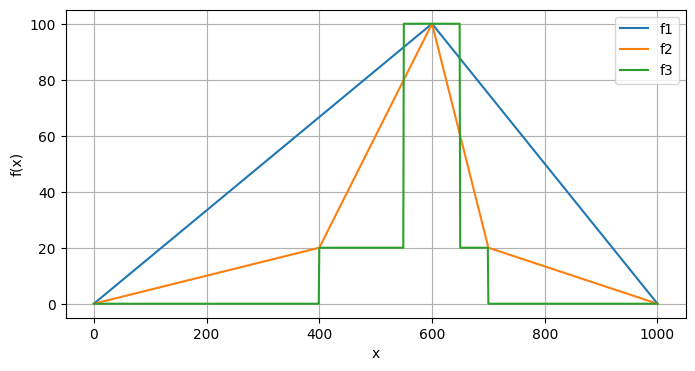

In [96]:
from piecewise_functions import PiecewiseConstantFunction, PiecewiseLinearFunction

f1 = PiecewiseLinearFunction(xs=[0, 600, 1000], ys=[0, 100, 0])
f2 = PiecewiseLinearFunction(xs=[0, 400, 600, 700, 1000], ys=[0, 20, 100, 20, 0])
f3 = PiecewiseConstantFunction(xs=[0, 400, 550, 650, 700, 1001], ys=[0, 20, 100, 20, 0])

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.xlabel("x")
plt.ylabel("f(x)")
x = range(0, 1001)
# plot all functions
for f, label in [(f1, "f1"), (f2, "f2"), (f3, "f3")]:
    plt.plot(x, [f(t) for t in x], label=label)
plt.grid()
plt.legend()
plt.show()

In [97]:
# create instance
import random

def generate_instance(k, num_items):
    items = [random.randint(1, 50) for _ in range(num_items)]
    return items

k = 50
num_items = 750
items = generate_instance(k, num_items)

In [98]:
from piecewise_functions import PiecewiseConstantFunctionConstraintViaDiff, PiecewiseLinearConstraint
from ortools.sat.python import cp_model

def create_model(k: int, items, f):
    model = cp_model.CpModel()
    x = [[model.NewBoolVar(f'x[{i}, {b}]')  for b in range(k)] for i in range(len(items))]
    for i in range(len(items)):
        model.AddAtMostOne(x[i])
    # How filled is bin b
    
    x_fill = [model.NewIntVar(0, 1000, f'x_fill[{i}]') for i in range(k)]
    # basic symmetry breaking
    for v, v_ in zip(x_fill[:-1], x_fill[1:]):
        model.Add(v <= v_)
    for b in range(k):
        model.Add(x_fill[b] == sum(x[i][b] * items[i] for i in range(len(items))))
    if isinstance(f, PiecewiseConstantFunction):
        y = [PiecewiseConstantFunctionConstraintViaDiff( x_fill_, f, model) for x_fill_ in x_fill]
    elif isinstance(f, PiecewiseLinearFunction):
        y = [PiecewiseLinearConstraint(model, x_fill_, f, upper_bound=True) for x_fill_ in x_fill]
    else:
        raise ValueError("Unknown function type")
    # objective
    model.Maximize(sum(y.y for y in y))
    return model, x_fill

In [99]:
model, x_fill = create_model(k, items, f1)
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 60
solver.parameters.log_search_progress = True
solver.parameters.relative_gap_limit = 0.01
status = solver.Solve(model)


Starting CP-SAT solver v9.9.3963
Parameters: max_time_in_seconds: 60 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0x9c8728bdc8a53e4f)
#Variables: 37'600 (#ints: 50 in objective)
  - 37'500 Booleans in [0,1]
  - 50 in [0,100]
  - 50 in [0,1000]
#kAtMostOne: 750 (#literals: 37'500)
#kLinear1: 100
#kLinear2: 149
#kLinearN: 50 (#terms: 37'550)

Starting presolve at 0.00s
  7.25e-03s  0.00e+00d  [DetectDominanceRelations] 
  3.48e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  9.44e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=750 #potential_subsets=50 
[Symmetry] Graph for symmetry has 75'199 nodes and 111'998 arcs.
[Symmetry] Symmetry computation done. time: 0.0552816 dtime: 0.0645792
[Symmetry] #generators: 700, average support size: 100
[Symmetry] 2500 orbits with sizes: 23,23,23,23,23,23,23,23,23,23,...
[Symmetry] Found orbitope of size 50 x 17


In [100]:
model, x_fill = create_model(k, items, f1)
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 60
solver.parameters.log_search_progress = True
solver.parameters.relative_gap_limit = 0.01
status = solver.Solve(model)


Starting CP-SAT solver v9.9.3963
Parameters: max_time_in_seconds: 60 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0x9c8728bdc8a53e4f)
#Variables: 37'600 (#ints: 50 in objective)
  - 37'500 Booleans in [0,1]
  - 50 in [0,100]
  - 50 in [0,1000]
#kAtMostOne: 750 (#literals: 37'500)
#kLinear1: 100
#kLinear2: 149
#kLinearN: 50 (#terms: 37'550)

Starting presolve at 0.00s
  8.23e-03s  0.00e+00d  [DetectDominanceRelations] 
  3.68e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  8.99e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=750 #potential_subsets=50 
[Symmetry] Graph for symmetry has 75'199 nodes and 111'998 arcs.
[Symmetry] Symmetry computation done. time: 0.0631248 dtime: 0.0645792
[Symmetry] #generators: 700, average support size: 100
[Symmetry] 2500 orbits with sizes: 23,23,23,23,23,23,23,23,23,23,...
[Symmetry] Found orbitope of size 50 x 17


In [101]:
model, x_fill = create_model(k, items, f1)
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 60
solver.parameters.log_search_progress = True
solver.parameters.relative_gap_limit = 0.01
status = solver.Solve(model)


Starting CP-SAT solver v9.9.3963
Parameters: max_time_in_seconds: 60 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0x9c8728bdc8a53e4f)
#Variables: 37'600 (#ints: 50 in objective)
  - 37'500 Booleans in [0,1]
  - 50 in [0,100]
  - 50 in [0,1000]
#kAtMostOne: 750 (#literals: 37'500)
#kLinear1: 100
#kLinear2: 149
#kLinearN: 50 (#terms: 37'550)

Starting presolve at 0.00s
  7.25e-03s  0.00e+00d  [DetectDominanceRelations] 
  3.43e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  9.06e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=750 #potential_subsets=50 
[Symmetry] Graph for symmetry has 75'199 nodes and 111'998 arcs.
[Symmetry] Symmetry computation done. time: 0.0553221 dtime: 0.0645792
[Symmetry] #generators: 700, average support size: 100
[Symmetry] 2500 orbits with sizes: 23,23,23,23,23,23,23,23,23,23,...
[Symmetry] Found orbitope of size 50 x 17
